## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 4-го спринта: "Создание рекомендательной системы"
***

## Содержание:
* [Инициализация (общая для всех этапов)](#step_0)
* [Этап 1. Первичная подготовка данных](#step_1)
* [Этап 2. Анализ данных (EDA)](#step_2)
* [Этап 3. Оффлайн-рекомендации](#step_3)
* [Итоговые выводы и сравнение результатов](#step_4)

## Инициализация (общая для всех этапов) <a id="step_0"></a>

In [1]:
# Убедимся, что работаем в нужном окружении
import sys

print(sys.executable)

/home/mle-user/.venv/bin/python


In [1]:
# Импортируем необходимые библиотеки

import os
import gc
from dotenv import load_dotenv
import boto3
from botocore.exceptions import ClientError

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

import joblib
import scipy
import sklearn.preprocessing
from catboost import CatBoostClassifier, Pool

In [2]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [31]:
# Загружаем переменные окружения

load_dotenv()

os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

In [32]:
# Создаем соединение с S3-хранилищем

session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=os.environ.get('S3_ENDPOINT_URL'),
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY')
)

## Этап 1. Первичная подготовка данных <a id="step_1"></a>

### Постановка задачи

Прочитайте файлы с данными, проведите оценку данных на наличие проблем:
- Нужно ли изменить тип идентификаторов?
- Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

При необходимости решите найденные проблемы.


### Описание исходных данных

Данные находятся в трёх файлах:

1. Данные о треках — в файле `tracks.parquet`:
    - `track_id` — идентификатор музыкального трека,
    - `albums` — список идентификаторов альбомов, содержащих трек,
    - `artists` — список идентификаторов исполнителей трека,
    - `genres` — список идентификаторов жанров, к которым принадлежит трек.

2. Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра),
    - `type` — тип идентификатора,
    - `name` — имя (название) каталожной единицы.

3. Данные о том, какие пользователи прослушали тот или иной трек — в файле `interactions.parquet`:
    - `user_id` — идентификатор пользователя,
    - `track_id` — идентификатор музыкального трека,
    - `track_seq` — номер места трека в истории пользователя,
    - `started_at` — дата начала прослушивания трека.

### Загрузка данных

In [6]:
# Устанавливаем утилиту wget, если ее нет
!pip install wget

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for wget, since package 'wheel' is not installed.
  Running setup.py install for wget ... done


In [9]:
!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet

100% [....................................................] 18938128 / 18938128
Saved under tracks.parquet
100% [....................................................] 36146495 / 36146495
Saved under catalog_names.parquet
100% [................................................] 1208078471 / 1208078471
Saved under interactions.parquet


### Предобработка данных

__Загружаем и проверяем данные из файла `tracks.parquet`__

In [10]:
tracks = pd.read_parquet("tracks.parquet")
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [11]:
# Смотрим типы колонок, кол-во строк, объем данных и наличие пропусков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Пропусков нет, типы корректны. Далее проверим `track_id` на наличие дубликатов и отрицательных значений

In [12]:
# Проверяем track_id на наличие дубликатов 
print(f"Все track_id уникальны: {tracks['track_id'].nunique() == len(tracks)}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(tracks['track_id'] < 0).sum()}")

Все track_id уникальны: True
Кол-во отрицательных track_id: 0


Повторяющихся и отрицательных track_id нет. 

В колонках `albums`, `artists` и `genres` списки могут быть пустыми либо содержать идентификаторы, указывающие на несуществующие каталожные единицы. Для экономии памяти оставим только те треки, у которых заполнены все четыре категории жанр/артист/альбом/название трека. Сделаем это после скачивания данных о каталогах.

__Загружаем и проверяем данные из файла `catalog_names.parquet`__

In [13]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [14]:
# Смотрим типы колонок, кол-во строк и объем данных
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [15]:
# Проверяем наличие пропусков
catalog_names.isnull().sum()

id      0
type    0
name    0
dtype: int64

Пропусков нет, типы колонок корректны. 

Сделаем еще несколько проверок

In [16]:
# Проверяем id на наличие повторяющихся значений
print(f"Кол-во уникальных id: {catalog_names['id'].nunique()}, общее кол-во строк: {len(catalog_names)}")

# Проверяем id на наличие отрицательных значений
print(f"Кол-во отрицательных id: {(catalog_names['id'] < 0).sum()}")

# Проверяем наличие повторяющихся строк
duplicated_rows_condition = catalog_names.duplicated(catalog_names.columns, keep=False)
print(f"Кол-во повторяющихся строк: {duplicated_rows_condition.sum()}")

Кол-во уникальных id: 1776697, общее кол-во строк: 1812471
Кол-во отрицательных id: 0
Кол-во повторяющихся строк: 0


Отрицательных id и повторяющихся строк нет, но есть одинаковые идентификаторы. 
Поскольку таких значений много, то вряд ли это связано со случайными ошибками.
Скорее всего, внутри каждого типа есть своя идентификация. Убедимся в этом

In [17]:
# Смотрим, какие есть каталожные типы
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [18]:
# Проверяем наличие повторяющихся id внутри типа album
cat_albums = catalog_names.query("type == 'album'")
print(f"Среди id альбомов нет повторяющихся значений: {cat_albums['id'].nunique() == len(cat_albums)}")

# Проверяем наличие повторяющихся id внутри типа artist
cat_artists = catalog_names.query("type == 'artist'")
print(f"Среди id артистов нет повторяющихся значений: {cat_artists['id'].nunique() == len(cat_artists)}")

# Проверяем наличие повторяющихся id внутри типа genre
cat_genres = catalog_names.query("type == 'genre'")
print(f"Среди id жанров нет повторяющихся значений: {cat_genres['id'].nunique() == len(cat_genres)}")

# Проверяем наличие повторяющихся id внутри типа track
cat_tracks = catalog_names.query("type == 'track'")
print(f"Среди id названий треков нет повторяющихся значений: {cat_tracks['id'].nunique() == len(cat_tracks)}")

Среди id альбомов нет повторяющихся значений: True
Среди id артистов нет повторяющихся значений: True
Среди id жанров нет повторяющихся значений: True
Среди id названий треков нет повторяющихся значений: True


Кол-во уникальных id внутри каждого типа равно общему кол-ву соответствующих каталожных единиц, значит повторяющихся id среди элементов одного типа действительно нет.

Далее вставим в таблицу треков названия соответствующих каталожных единиц вместо их идентификаторов

In [19]:
# Разворачиваем tracks по каталожным ids и переименовываем колонки
tracks_exploded = tracks.explode('albums', ignore_index=True) \
    .explode('artists', ignore_index=True) \
        .explode('genres', ignore_index=True) \
            .rename(columns={'albums':'album_id', 'artists': 'artist_id', 'genres': 'genre_id'})

In [20]:
# Оставляем только треки, у которых заполнены все 3 категории артист/жанр/альбом
id_columns = ['album_id', 'artist_id', 'genre_id']
tracks_exploded = tracks_exploded[~tracks_exploded[id_columns].isnull().any(axis=1)]

In [21]:
# Посмотрим, сколько осталось уникальных треков из 1 млн
tracks_exploded['track_id'].nunique()

980977

In [22]:
# Меняем тип идентификаторов с object на int
tracks_exploded[['album_id', 'artist_id', 'genre_id']] = \
    tracks_exploded[['album_id', 'artist_id', 'genre_id']].astype('int')

In [23]:
# Вставляем в tracks_exploded имена альбомов
tracks_exploded = tracks_exploded \
    .merge(cat_albums[['id', 'name']], how='left', left_on='album_id', right_on='id') \
        .rename(columns={'name': 'album_name'}).drop(columns='id')

In [24]:
# Вставляем в tracks_exploded имена артистов
tracks_exploded = tracks_exploded \
    .merge(cat_artists[['id', 'name']], how='left', left_on='artist_id', right_on='id') \
        .rename(columns={'name': 'artist_name'}).drop(columns='id')

In [25]:
# Вставляем в tracks_exploded названия жанров
tracks_exploded = tracks_exploded\
    .merge(cat_genres[['id', 'name']], how='left', left_on='genre_id', right_on='id')\
        .rename(columns={'name': 'genre_name'}).drop(columns='id')

Сворачиваем полученный `tracks_exploded` по названиям альбомов/артистов/жанров и добавляем названия треков

In [26]:
# Удаляем колонки с id каталогов
tracks_exploded.drop(columns=['artist_id', 'genre_id', 'album_id'], inplace=True)

In [27]:
# Сворачиваем названия каталогов в списки
tracks = tracks_exploded.groupby('track_id') \
    .agg({'album_name': lambda x: x.tolist(), 'artist_name': lambda x: x.tolist(), 'genre_name': lambda x: x.tolist()}) \
        .rename({'album_name': 'albums', 'artist_name': 'artists', 'genre_name': 'genres'}, axis=1) \
            .reset_index()

In [28]:
# Удаляем повторяющиеся названия в списках каталогов
tracks['albums'] = tracks['albums'].apply(lambda x: list(set(x)))
tracks['artists'] = tracks['artists'].apply(lambda x: list(set(x)))
tracks['genres'] = tracks['genres'].apply(lambda x: list(set(x)))

In [29]:
# Вставляем названия треков
tracks = tracks \
    .merge(cat_tracks[['id', 'name']], how='left', left_on='track_id', right_on='id') \
        .drop(columns='id')

Проверим, есть ли треки без названий

In [30]:
print(f"Кол-во треков без названий: {tracks['name'].isnull().sum()}")

Кол-во треков без названий: 0


In [31]:
# Смотрим, что получилось
tracks.head()

,track_id,albums,artists,genres,name
0,26,[Taller Children],[Elizabeth & the Catapult],"[folk, pop]",Complimentary Me
1,38,[Taller Children],[Elizabeth & the Catapult],"[folk, pop]",Momma's Boy
2,135,[Wild Young Hearts],[Noisettes],[pop],Atticus
3,136,[Wild Young Hearts],[Noisettes],[pop],24 Hours
4,138,"[I Am On Holiday, Don't Upset The Rhythm, Club...",[Noisettes],[pop],Don't Upset The Rhythm (Go Baby Go)


__Загружаем и проверяем данные из файла `interactions.parquet`__

In [32]:
interactions = pd.read_parquet("interactions.parquet")
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [33]:
# Смотрим типы колонок, кол-во строк и объем данных
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [34]:
# Проверяем наличие пустых значений
interactions.isnull().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Пропусков нет, тип int32 у идентификаторов оставим без изменений для экономии памяти. Сделаем такой же тип и в `tracks`, но сначала убедимся, что значения `track_id` в `tracks` не превышают максимума для этого типа

In [35]:
print(f"Максимальное значение track_id: {tracks['track_id'].max()}")
print(f"Максимальное значение для int32: {2**32 - 1}")

Максимальное значение track_id: 101521819
Максимальное значение для int32: 4294967295


Таким образом, приведение к int32 допустимо

In [22]:
# Приводим track_id к int32 для экономии памяти
tracks['track_id'] = tracks['track_id'].astype('int32')

Далее проверим корректность значений `user_id`, `track_id` и `track_seq`

In [51]:
# Проверяем user_id на наличие отрицательных значений
print(f"Кол-во отрицательных user_id: {(interactions['user_id'] < 0).sum()}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(interactions['track_id'] < 0).sum()}")

# Проверяем track_seq на наличие отрицательных и нулевых значений 
# (track_seq не могут быть нулевыми по смыслу)
print(f"Кол-во неположительных track_seq: {(interactions['track_seq'] <= 0).sum()}")

Кол-во отрицательных user_id: 0
Кол-во отрицательных track_id: 0
Кол-во неположительных track_seq: 0


Оставим в `interactions` прослушивания только тех треков, которые есть в `tracks`

In [36]:
# Фильтруем треки в таблице взаимодействий
interactions = interactions[interactions['track_id'].isin(tracks['track_id'])]

# Смотрим, сколько осталось событий после удаления
len(interactions)

222184449

Событий все еще слишком много. Для экономии ресурсов сократим размер датасета с 5.4G до 1.5-2G, 
т.е. примерно в 3 раза. Для этого удалим из истории каждого пользователя около 2/3 треков,
оставив только треки на позициях 1,4,7 итд.

In [37]:
# Оставляем в истории всех пользователей только каждый 3-й трек, начиная с 1-го
interactions = interactions[(interactions['track_seq'] + 2) % 3 == 0]

Посмотрим, объем памяти и кол-во строк в `interactions` после всех удалений

In [38]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74514648 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 1.8 GB


Теперь колонку `track_seq` можно удалить, т.к. она по сути дублирует `started_at` и является лишней

In [39]:
# Удаляем колонку track_seq для экономии памяти
interactions.drop(columns='track_seq', inplace=True)

Проверим, есть ли в `interactions` повторяющиеся пары пользователь/трек

In [27]:
duplicates_condition = interactions.duplicated(['user_id', 'track_id'], keep=False)
print(f"Кол-во повторяющихся пар user_id, track_id: {duplicates_condition.sum()}")

Кол-во повторяющихся пар (user_id, track_id): 0


В конце переименуем таблицы `tracks`, `interactions`, колонку `track_id` и сохраним обновленные таблицы в двух новых файлах

In [41]:
# Переименовываем колонки
tracks.rename(columns={'track_id': 'item_id'}, inplace=True)
interactions.rename(columns={'track_id': 'item_id'}, inplace=True)

In [42]:
# Переименовываем таблицы
items = tracks
events = interactions

In [13]:
# Сохраняем треки и события в 2-х новых файлах
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

Очищаем память 

In [43]:
# Удаляем из памяти уже ненужные данные
del catalog_names

# Принудительное вызываем сборщик мусора для освобождения памяти
gc.collect()

Удаляем исходные файлы

In [7]:
file_name = "tracks.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

file_name = "catalog_names.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

file_name = "interactions.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

File tracks.parquet removed successfully
File catalog_names.parquet removed successfully
File interactions.parquet removed successfully


### Выводы по 1-му этапу

- Проверили исходные данные на наличие пропусков, дубликатов, некорректных типов, 
значений и связей между таблицами. Для экономии ресурсов оставили только треки, 
где были заполнены все четыре категории жанр/артист/альбом/название трека. 
Из истории прослушиваний убрали строки, соответствующие удаленным трекам;
- По той же причине сократили датасет событий примерно в 3 раза с 5.4G до 1.5-2G, 
для этого у всех пользователей удалили около 2/3 прослушиваний 
(в истории каждого пользователя оставили только треки на позициях 1,4,7 итд), 
после чего удалили колонку `track_seq`;
- Также для экономии памяти оставили тип int32 у идентификаторов пользователей и треков в таблице `interactions`,
соответствующую колонку в таблице `tracks` привели к тому же типу;
- Предобработанные данные о треках и прослушиваниях сохранены в файлах `items.parquet` и `events.parquet`.

## Этап 2. Анализ данных (EDA) <a id="step_2"></a>

### Постановка задачи

Проведите EDA данных, чтобы получить представление о следущих параметрах:
- распределение количества прослушанных треков,
- наиболее популярные треки,
- наиболее популярные жанры,
- треки, которые никто не прослушал.

Сохраните данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

Чтобы избежать проблем с памятью, __перезапускаем ядро__, выполняем ячейки в разделе `Инициализация` и загружаем данные

In [8]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Посмотрим распределение кол-ва прослушиваний треков и уникальных пользователей по месяцам.

In [8]:
from pandas.tseries.offsets import MonthEnd

# Добавляем колонку с начальными датами для каждого месяца
events["started_at_month"] = events["started_at"].dt.to_period('M').dt.to_timestamp().dt.date

In [9]:
# Группируем события по месяцам
events_by_month = events.groupby("started_at_month")\
    .agg(events=("started_at", "count"), users=("user_id", "nunique"))\
        .reset_index()

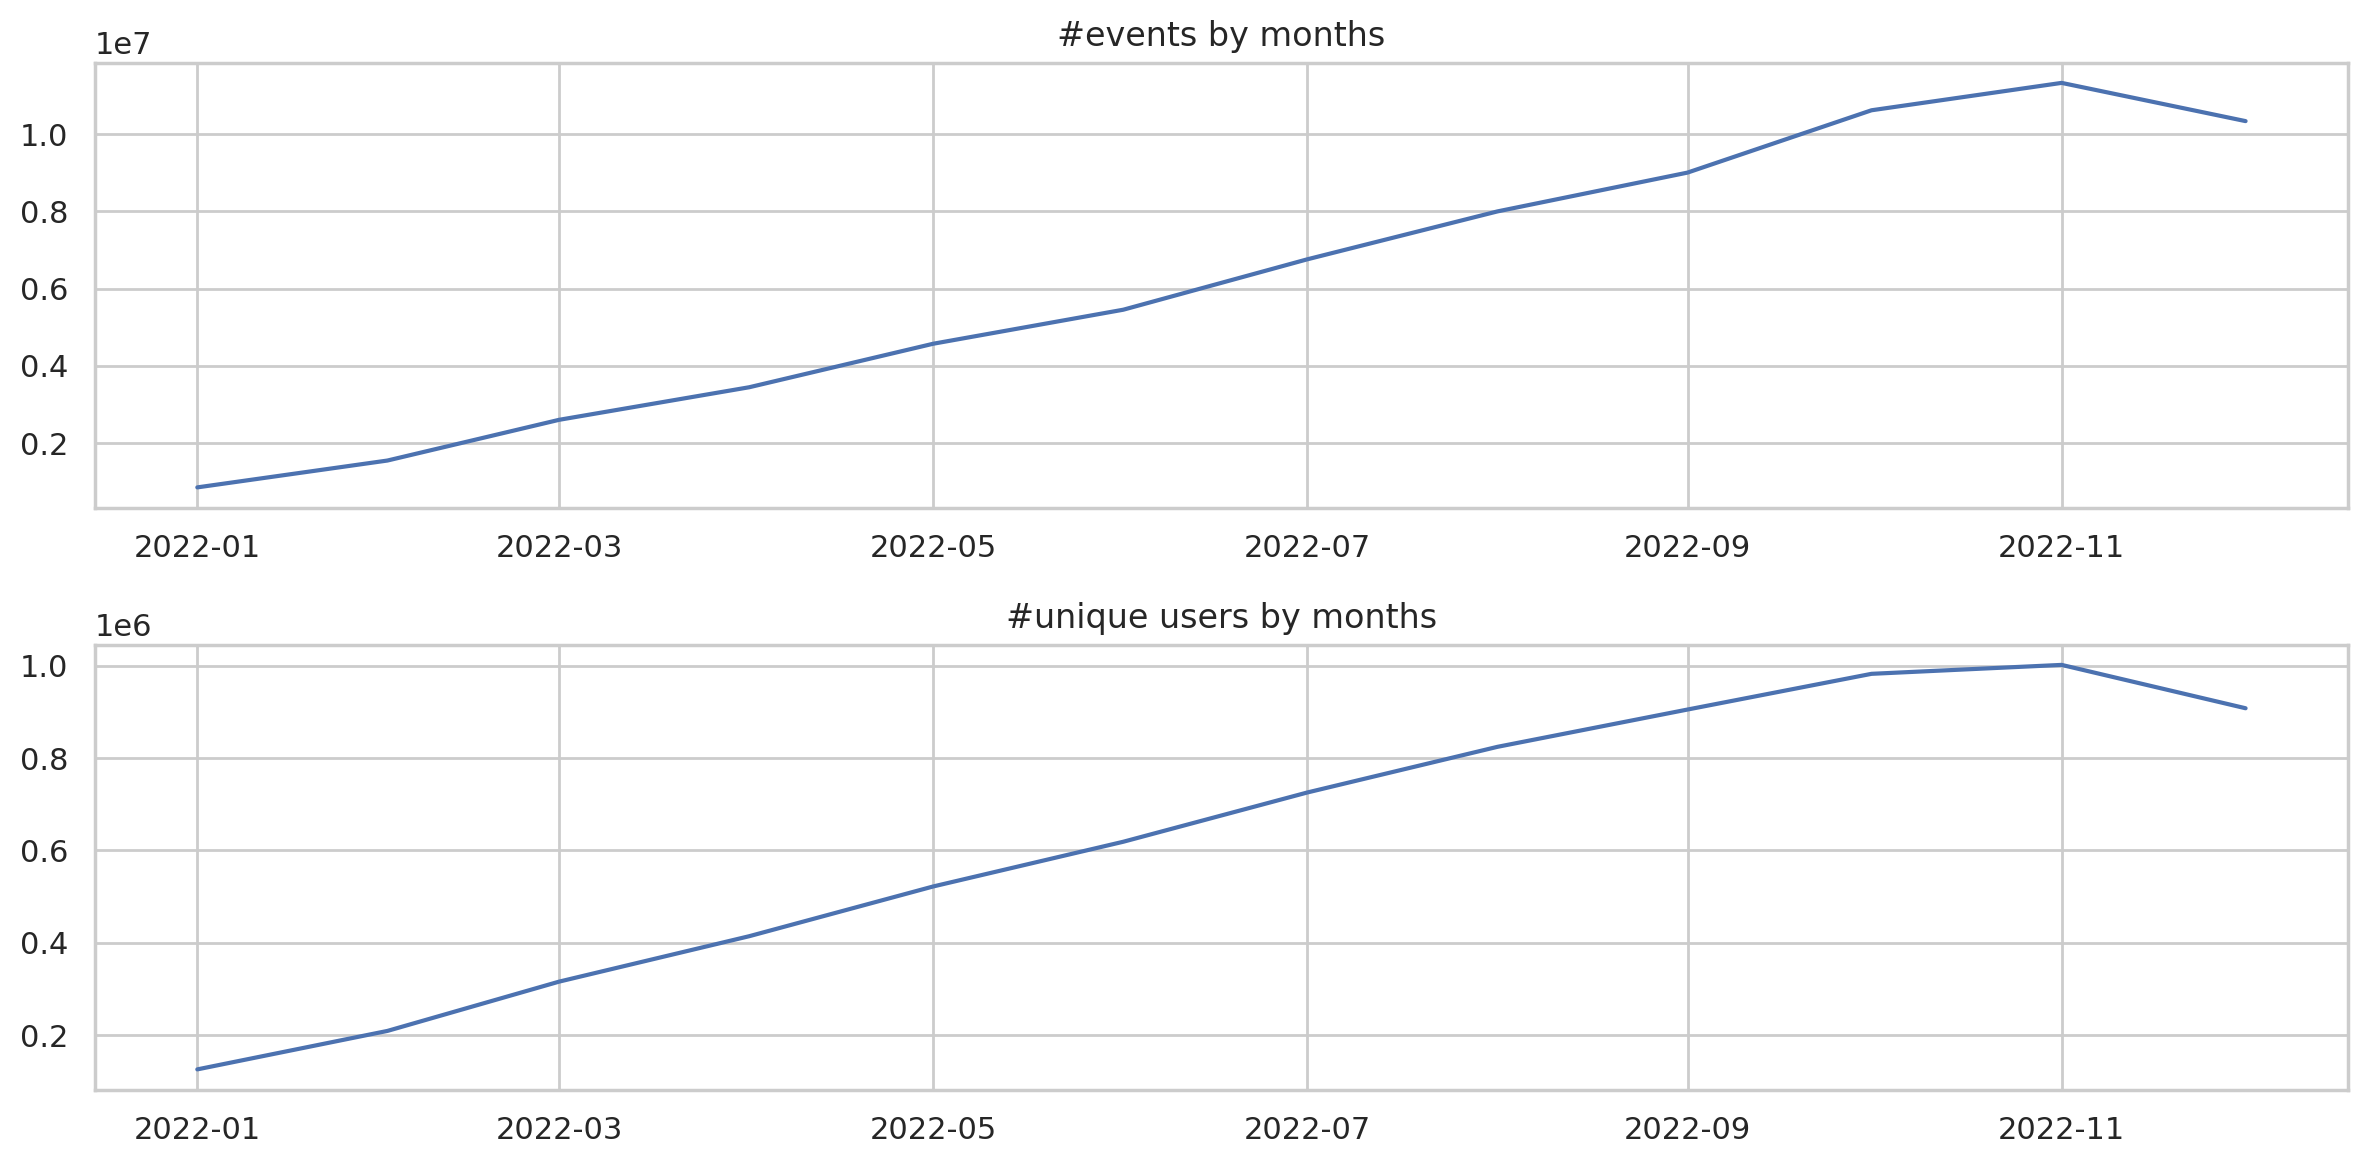

In [10]:
# Визуализируем распределение кол-ва взаимодействий и уникальных пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_by_month["started_at_month"], events_by_month["events"])
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_by_month["started_at_month"], events_by_month["users"])
ax.set_title("#unique users by months")

fig.tight_layout()

Видим, что история взаимодействий охватывает только 2022 г. Кол-во прослушиваний и уникальных пользователей постепенно росли вплоть до ноября, после чего начали немного снижаться. Возможно, сервис был запущен в самом начале 2022 г., его пик популярности пришелся на ноябрь и затем начал спадать. Такое изменение в распределении данных может привести к ухудшению метрик качества рекомендаций при валидации.

Найдем топ-100 наиболее популярных треков по общему кол-ву прослушиваний. Для этого сначала разобьем события на train и test, чтобы считать искать топ треки только на train (так мы избежим утечки информации о таргете в тестовую выборку)

In [ ]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [ ]:
# Удаляем из памяти лишние данные
del events
del events_test
gc.collect()

In [14]:
pop_items = events_train \
    .groupby("item_id").agg(plays=("started_at", "count"), users=("user_id", "nunique")).reset_index()

# Сортируем по убыванию кол-ва прослушиваний, а при их равенстве - по убыванию уникальных пользователей
pop_items = pop_items.sort_values(['plays', 'users'], ascending=[False, False])

# Выбираем первые 100 самых прослушиваемых треков 
top_k_pop_items = pop_items[:100].reset_index().drop(columns='index')

In [15]:
# Добавляем колонки с названиями всех каталожных единиц
top_k_pop_items = top_k_pop_items \
    .merge(items[['item_id', 'name', 'genres', 'artists', 'albums']], how='inner', on='item_id')

# Добавляем колонку rank
top_k_pop_items = top_k_pop_items.reset_index().rename(columns={'index': 'rank'})
top_k_pop_items['rank'] += 1

top_k_pop_items

,rank,item_id,plays,users,name,genres,artists,albums
0,1,53404,41366,41366,Smells Like Teen Spirit,"[allrock, alternative, rock]",[Nirvana],"[Skiing Music, Nirvana, Nevermind, Smells Like..."
1,2,33311009,35952,35952,Believer,"[allrock, rock]",[Imagine Dragons],"[Summertime Love, Family Friendly Summer Hits,..."
2,3,178529,35841,35841,Numb,"[numetal, metal]",[Linkin Park],"[Meteora, 00s Rock Anthems]"
3,4,35505245,33638,33638,I Got Love,"[rusrap, rap]","[Miyagi & Эндшпиль, Рем Дигга]",[I Got Love]
4,5,37384,30686,30686,Zombie,"[allrock, rock]",[The Cranberries],"[***** ***, Gold, MNM Sing Your Song: Back To ..."
...,...,...,...,...,...,...,...,...
95,96,54400255,17313,17313,Señorita,[pop],"[Shawn Mendes, Camila Cabello]","[Spring Fling, Straight Up Anthems, Hits Of Th..."
96,97,68348389,17313,17313,Minor,"[rusrap, rap]",[Miyagi & Andy Panda],[YAMAKASI]
97,98,34735046,17287,17287,Devil Eyes,[electronics],[Hippie Sabotage],[Providence]
98,99,33308946,17253,17253,Вахтёрам,"[ukrrock, allrock]",[Бумбокс],[Family бізнес]


Сохраняем эти данные в файл `top_popular.parquet` для последующего использования в качестве готовых рекомендаций по умолчанию

In [16]:
top_k_pop_items.to_parquet('top_popular.parquet')

Определим самые популярные жанры. Для этого пройдемся по только что отобранным топ-трекам и посчитаем, к каким жанрам они относятся. Жанры с наибольшей встречаемостью будут самыми популярными

In [17]:
# Функция для извлечения жанров из треков
def get_genres(items):

    """ 
    Извлекает жанры из треков и считает, сколько раз встречается каждый жанр.
    """    
    genres_counter = {}
    
    for k, v in items.iterrows():
        if v["genres"] is None: # После предобработки NA быть не может, оставили для общего случая
            continue
        
        genres = list(v["genres"])

        for genre in genres:
            try:
                genres_counter[genre] += 1 
            except KeyError:
                genres_counter[genre] = 1

    genres = pd.Series(genres_counter, name="items_count")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"

    return genres

In [18]:
# Извлекаем жанры из самых популярных треков и считаем score для каждого жанра, как долю от общего кол-ва треков
top_k_pop_items_genres = get_genres(top_k_pop_items)
top_k_pop_items_genres["score"] = top_k_pop_items_genres["items_count"] / top_k_pop_items_genres["items_count"].sum()

Text(0.5, 1.0, 'Top 10 most played genres')

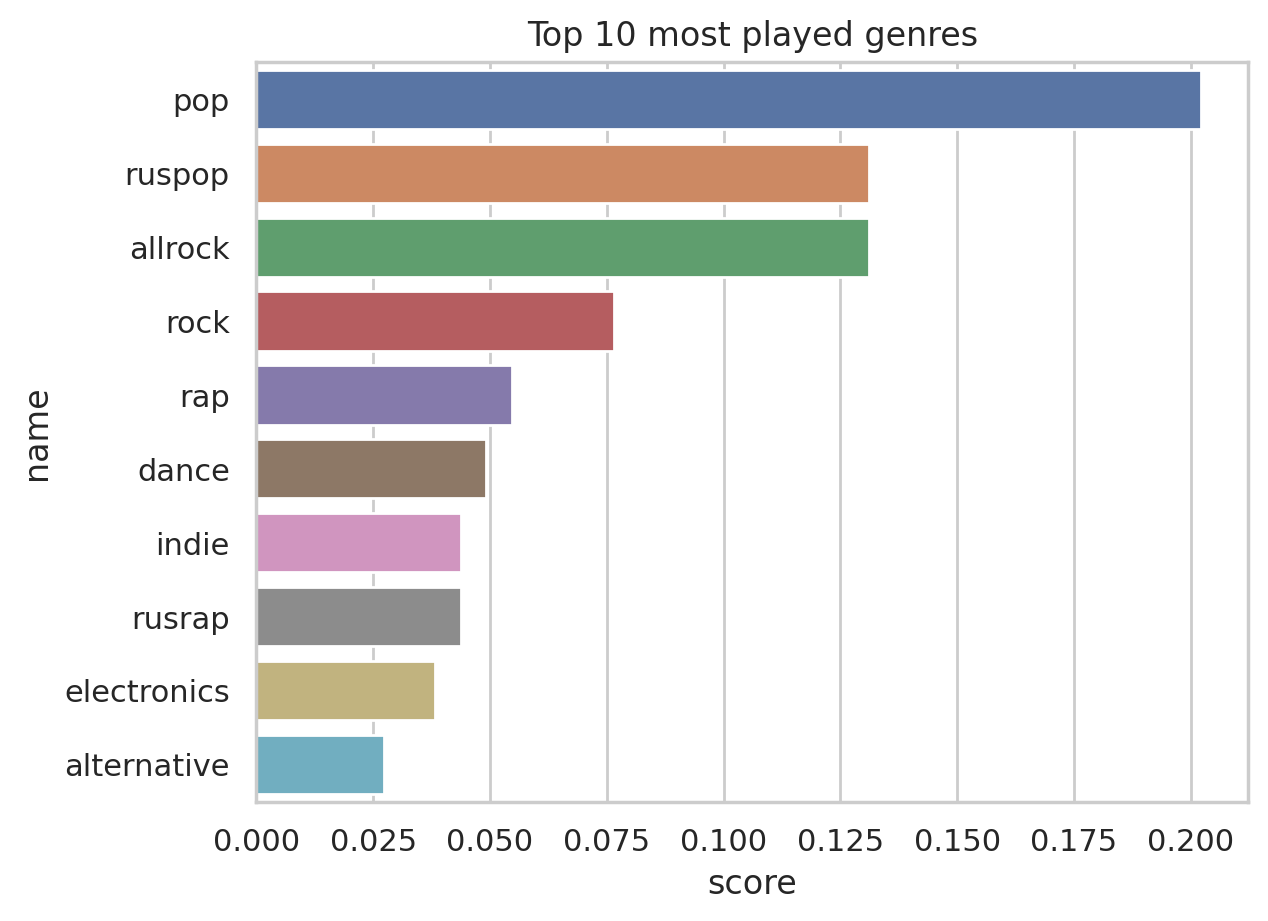

In [21]:
# Строим горизонтальный barplot
sns.barplot(data=top_k_pop_items_genres.sort_values(by="score", ascending=False).head(10), x='score', y='name').set_title("Top 10 most played genres")

Таким образом, среди топ-100 самых прослушиваемых треков наиболее распространенным жанром является pop.

Также подготовим список жанров по всем трекам. Он понадобится для построения матрицы треки-жанры

In [22]:
# Извлекаем жанры по всем трекам
genres = get_genres(items)
genres["score"] = genres["items_count"] / genres["items_count"].sum()

In [23]:
# Смотрим отсортированный список жанров
genres.sort_values(by="score", ascending=False)

,name,items_count,score
genre_id,,,
1,pop,166284,0.103221
20,rap,128212,0.079588
3,allrock,118506,0.073563
11,electronics,114232,0.070910
6,metal,72311,0.044887
...,...,...,...
127,business,7,0.000004
128,religion,4,0.000002
135,technologies,4,0.000002


После удаления части треков на этапе предобработки у нас получилось 137 разных жанров. Из них топ-3 самых распространенных: pop, rap и allrock.

Сохраняем жанры для последующего использования

In [40]:
# Сохраняем жанры в файл
genres.to_parquet('genres.parquet')

Проверим кол-во непрослушанных треков, т.е. таких, которые есть в `items`, но нет в `events`

In [24]:
# Уникальные id всех треков
all_items_ids = set(items['item_id'])
        
# Уникальные id только прослушанных треков
played_items_ids = set(events['item_id'].unique()) 

# Треки, которые есть в items, но нет в events
not_played_items_ids = list(all_items_ids - played_items_ids)
print(f"Кол-во непрослушанных треков: {len(not_played_items_ids)}")

Кол-во непрослушанных треков: 21716


Видим, что после сокращения истории взаимодействий появилось много непрослушанных треков,
но мы не будем их удалять, т.к. по ним все равно можно строить контентные рекомендации. 

В конце загружаем файлы с объектами и событиями в S3-хранилище

In [16]:
# Сохраняем файлы в S3-хранилище
s3_client.upload_file('items.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/data/items.parquet')
s3_client.upload_file('events.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/data/events.parquet')

## Этап 3. Оффлайн-рекомендации <a id="step_3"></a>

### Постановка задачи

Подготовьте данные для обучения:
- Загрузите ранее сохранённые данные из файлов `items.parquet`, `events.parquet`;
- Разбейте данные на тренировочную и тестовую выборки: в тренировочную отнесите все данные до __16 декабря 2022 г. (не включительно)__.

Рассчитайте рекомендации нескольких типов, сохраните каждый тип в своём файле в персональном S3-бакете по пути `recsys/recommendations/`:
- топ популярных — в `top_popular.parquet`,
- персональные (при помощи ALS) — в `personal_als.parquet`,
- похожие треки или i2i (при помощи ALS) — в `similar.parquet`.

Постройте ранжирующую модель, которая использует минимум три признака. Отранжируйте рекомендации, а итоговые сохраните в `recommendations.parquet`.

Проверьте оценку качества трёх типов рекомендаций: 
1. топ популярных,
2. персональных, полученных при помощи ALS,
3. итоговых (по метрикам: recall, precision, coverage, novelty).

Приведите значения метрик в ноутбуке.

### Загрузка и разбиение данных

Чтобы избежать проблем с памятью, __перезапускаем ядро__, выполняем ячейки в разделе `Инициализация` и загружаем данные

In [5]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Разбиваем данные на тренировочную и тестовую выборки (в последнюю относим данные строго до 16 декабря 2022 г.)

In [6]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

### Рекомендации на основе самых популярных треков

Загружаем ранее сохраненные топ-треки и оцениваем качество рекомендаций на их основе для "холодных" пользователей

In [8]:
# Загружаем топ-100 самых прослушиваемых треков
top_k_pop_items = pd.read_parquet("top_popular.parquet")
top_k_pop_items.head()

,rank,item_id,plays,users,name,genres,artists,albums
0,1,53404,41366,41366,Smells Like Teen Spirit,"[allrock, alternative, rock]",[Nirvana],"[Skiing Music, Nirvana, Nevermind, Smells Like..."
1,2,33311009,35952,35952,Believer,"[allrock, rock]",[Imagine Dragons],"[Summertime Love, Family Friendly Summer Hits,..."
2,3,178529,35841,35841,Numb,"[numetal, metal]",[Linkin Park],"[Meteora, 00s Rock Anthems]"
3,4,35505245,33638,33638,I Got Love,"[rusrap, rap]","[Miyagi & Эндшпиль, Рем Дигга]",[I Got Love]
4,5,37384,30686,30686,Zombie,"[allrock, rock]",[The Cranberries],"[***** ***, Gold, MNM Sing Your Song: Back To ..."


In [25]:
# Идентификаторы уникальных пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [26]:
# Идентификаторы "холодных" пользователей
cold_users = users_test[~users_test.isin(users_train)]
print(f"Кол-во холодных пользователей: {len(cold_users)}")

Кол-во холодных пользователей: 30659


Посчитаем долю треков «холодных» пользователей, совпавших с треками из числа топ-популярных (т.е. с рекомендациями по умолчанию)

In [27]:
# Формируем бинарную колонку match для подсчета числа совпадений

top_k_pop_items['match'] = 1

cold_users_events = \
    events_test[events_test["user_id"].isin(cold_users)] \
        .merge(top_k_pop_items[['item_id', 'match']], on="item_id", how="left")

cold_users_events['match'].fillna(0, inplace=True)

In [30]:
# Доля треков "холодных" пользователей, совпавших с рекомендациями по умолчанию
cold_users_events_match_share = cold_users_events['match'].sum() / len(cold_users_events)
cold_users_events_match_share

0.05824794020621842

Считаем покрытие "холодных" пользователей рекомендациями из числа топ-треков

In [33]:
# Группируем холодных пользователей по их id
cold_users_hit_ratio = cold_users_events.groupby("user_id").agg(hits=("match", 'sum'))

print(f"Доля холодных пользователей без релевантных рекомендаций: \
      {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие холодных пользователей: \
      {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля холодных пользователей без релевантных рекомендаций: 0.62
Среднее покрытие холодных пользователей: 1.87


Таким образом, у порядка 40% "холодных" пользователей прослушивания на тестовой выборке совпали с рекомендации по умолчанию из числа топ-популярных треков, что можно считать неплохим результатом. 
При этом на каждого из них пришлось в среднем около 2-х треков.

### Персональные рекомендации на основе коллаборативного подхода и ALS

[Техническая документация на библиотеку implicit](https://benfred.github.io/implicit/api/models/cpu/als.html)

Перекодируем идентификаторы `user_id` и `item_id`

In [7]:
# Перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# Перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train = events_train.merge(items[["item_id", "item_id_enc"]], on="item_id", how='left')
events_test = events_test.merge(items[["item_id", "item_id_enc"]], on="item_id", how='left')

Создаем sparse-матрицу в формате [CSR](https://docs.scipy.org/doc/scipy/reference/sparse.html)

In [9]:
# Формируем колонку target (1 - трек прослушан, 0 - нет)
events_train['target'] = 1

# Создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["target"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

Имея подготовленную матрицу взаимодействий, создаем ALS-модель. 
Для примера возьмём количество латентных факторов для матриц $P и Q$ равным 50. 

In [36]:
# Код для создания и тренировки модели
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [37]:
# Сохраняем als-модель в файл
os.makedirs('models/', exist_ok=True)
with open('models/als_model.pkl', 'wb') as fd:
    joblib.dump(als_model, fd)

Чтобы получить рекомендации для отдельного пользователя с помощью модели ALS, используем функцию ниже

In [38]:
def get_recommendations_als(user_item_matrix, als_model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = als_model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

Посмотрим историю и рекомендации для случайного пользователя

In [41]:
# Выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]
print(f"user_id: {user_id}")

print("Последние события:")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["name", "genres", "albums", "artists"]], on="item_id")
)
user_history_to_print = user_history[["item_id", "name", "genres", "albums", "artists"]].tail(10)
display(user_history_to_print)

print("Рекомендации:")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder, include_seen=True, n=10)
user_recommendations = user_recommendations.merge(items.set_index("item_id")[["name", "genres", "albums", "artists"]], on="item_id")
user_recommendations_to_print = \
    user_recommendations[["item_id", "name", "genres", "albums", "artists", "score"]].head(10)
display(user_recommendations_to_print)

user_id: 191352
Последние события:


,item_id,name,genres,albums,artists
110,84171385,Darkness,[electronics],[Pathways EP],[Fate]
111,84670890,Ты была права,"[rusrap, rap]",[Ты была права],[Баста]
112,84980677,Ронин,"[rusrap, rap]",[Ронин],"[Скриптонит, The Limba]"
113,85149354,Slumber Party,[pop],[Slumber Party],"[Ashnikko, Plah]"
114,85721165,Voiceless 2021,[dance],[Infinity and Beyond 2.0],"[R-Tem, Max Tarconi]"
115,86746096,Not Enough,[dance],[Outside],[Biicla]
116,87902717,Phonky Town,"[foreignrap, rap]",[Phonky Town],[Playaphonk]
117,88253142,SUICIDE YEAR,"[foreignrap, rap]",[SUICIDE YEAR],"[WEEDMANE, Suicideyear]"
118,89081846,abcdefu,[pop],[abcdefu],[GAYLE]
119,89718151,As the World Caves In,[pop],"[Top Trending Romania - Vara 2021, As the Worl...","[Sarah Cothran, Wuki]"


Рекомендации:


,item_id,name,genres,albums,artists,score
0,60292250,Blinding Lights,[rnb],"[After Hours, Blinding Lights, The Highlights]",[The Weeknd],0.727187
1,47627256,Cradles,[electronics],[Cradles],[Sub Urban],0.321736
2,55561798,Аugust,[electronics],"[Renovatio, August]",[Intelligency],0.228013
3,8264,Paper Planes,"[None, electronics]","[College Hip Hop, Pay Close Attention : XL Rec...",[M.I.A.],0.209865
4,34735046,Devil Eyes,[electronics],[Providence],[Hippie Sabotage],0.193408
5,75944934,Astronaut In The Ocean,"[foreignrap, rap]","[Astronomical, Astronaut In The Ocean]",[Masked Wolf],0.168895
6,84019953,Close Eyes,"[foreignrap, rap]",[Close Eyes],[DVRST],0.151053
7,58723120,Odium,"[foreignrap, rap]",[Universe of the Past],"[LXST CXNTURY, Kingpin Skinny Pimp]",0.148858
8,9060176,Sweater Weather,[indie],"[I Love You., Love Bops 2022, Simping Songs, I...",[The Neighbourhood],0.144889
9,18820599,Come And Get Your Love,"[allrock, electronics, rock]","[Love Bops 2022, Guardians of the Galaxy: Awes...",[Redbone],0.142051


Видим, что рекомендации хорошо мэтчатся с историей пользователя.

Получим по 50 рекомендаций для всех пользователей из `events`

In [10]:
# Получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# Получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=50)

Код возвращает рекомендации как список списков, что не очень удобно. Преобразуем его в более удобный табличный формат

In [11]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [13]:
# Смотрим, что получилось
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations

,user_id,item_id,score
0,0,18860,0.008680
1,0,18385776,0.008127
2,0,60292250,0.007501
3,0,597196,0.007165
4,0,29175370,0.006840
...,...,...,...
68635745,1374582,41631554,0.038625
68635746,1374582,78619463,0.038531
68635747,1374582,70619465,0.038283
68635748,1374582,2758009,0.037921


In [14]:
# Сохраним полученные рекомендации в файл
als_recommendations.to_parquet("personal_als.parquet")

Найдем покрытие по объектам

In [15]:
cov_items = als_recommendations['item_id'].nunique() / len(items) 
print(cov_items)

0.004089800270546608


Посчитаем среднее Novelty@5, для этого:
- разметим каждую рекомендацию в als_recommendations булевым признаком played, используя events_train
(False — пользователь не прослушал трек, True — прослушал),
- посчитаем Novelty@5 для каждого пользователя,
- найдем среднее значение полученных Novelty@5.

In [16]:
# разметим каждую рекомендацию признаком played
events_train["played"] = True
als_recommendations = als_recommendations \
    .merge(events_train[['played', "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
als_recommendations["played"] = als_recommendations["played"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values(by='score', ascending=False) 
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - als_recommendations.query("rank <= 5").groupby("user_id")["played"].mean())

# посчитаем средний novelty
novelty_5_mean = novelty_5.mean()
print(novelty_5_mean)

0.7915405601308352


Посчитаем recall и precision для ALS-рекомендаций. Для этого события в тестовой выборке и рекомендации для одних и тех же пользователей разметим признаками:
- gt (ground truth): объект есть в тестовой выборке;
- pr (predicted): объект есть в рекомендациях.

Теперь разметим признаки бинарной классификации:
- TP: объект есть и в тестовой выборке, и в рекомендациях (истинная рекомендация),
- FP: объекта нет в тестовой выборке, но он есть в рекомендациях (ложноположительная рекомендация),
- FN: объект есть в тестовой выборке, но его нет в рекомендациях (ложноотрицательная рекомендация)

Создаем функцию для подсчета метрик TP, FP и FN у пользователей, которые есть одновременно и в events_train,
и в events_test

In [18]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

Считаем TP, FP и FN для каждой пары user_id, item_id

In [18]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(events_train,
                                                                        events_test, 
                                                                        als_recommendations,
                                                                        top_k=5)

Common users: 661812


Считаем precision и recall

In [24]:
def compute_cls_metrics(events_recs_for_binary_metrics):
    
    groupper = events_recs_for_binary_metrics.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum()) 
    recall = recall.fillna(0).mean()

    return precision, recall

In [20]:
precision, recall = compute_cls_metrics(events_recs_for_binary_metrics)
print(precision, recall)

0.0022163393833898454 0.003603471740681325


### Рекомендации на основе контентного подхода и ALS

Для экономии ресурсов не будем строить контентные рекомендации для всех пользователей. Вместо этого 
найдем только матрицу треки-жанры для всех треков. Она понадобится для генерации жанровых признаков.

Сначала загрузим список жанров по всем трекам

In [19]:
genres = pd.read_parquet('genres.parquet')
genres.head()

,name,items_count,score
genre_id,,,
0,pop,166284,0.103221
1,folk,37547,0.023307
2,allrock,118506,0.073563
3,hardrock,10916,0.006776
4,rock,55174,0.034249


Функция ниже строит матрицу треки-жанры

In [20]:
def get_item2genre_matrix(genres, items):

    genre_names_to_id = genres.reset_index().set_index("name")["genre_id"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):
        if v["genres"] is None: # После предобработки NA быть не может, оставили для общего случая
            continue
        
        item_genres = list(v["genres"])
        
        for genre_name in item_genres:
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(1)
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), \
                                         shape=(len(items), len(genres)))
    
    # нормализуем, чтобы сумма оценок принадлежности к жанрам была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

Строим матрицу с весами по всем трекам и жанрам

In [21]:
items = items.sort_values(by="item_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)

Сохраним полученную матрицу на диск

In [23]:
# Сохраняем csr-матрицу треки-жанры
scipy.sparse.save_npz('all_items_genres_csr.npz', all_items_genres_csr)

### Рекомендации на основе похожих треков (i2i) и ALS

Получим рекомендации при помощи метода [similar_items](https://benfred.github.io/implicit/api/models/cpu/als.html) 
для всех треков из `events_train`

In [8]:
# Загружаем ALS-модель
with open('models/als_model.pkl', 'rb') as fd:
    als_model = joblib.load(fd)

In [58]:
# Получим энкодированные идентификаторы объектов в events_train
train_item_ids_enc = events_train['item_id_enc'].unique() 

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()}) 
similar_items = similar_items.explode(['sim_item_id_enc', 'score'], ignore_index=True) 

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype('int') 
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"]) 
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"]) 
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [59]:
# Смотрим результат
similar_items.head()

,score,item_id_1,item_id_2
1,0.927705,99262,99245
2,0.912948,99262,99241
3,0.905223,99262,4637878
4,0.897252,99262,99254
5,0.894859,99262,40667264


In [60]:
# Сохраняем полученные рекомендации в файл
similar_items.to_parquet("similar.parquet")

С помощью функции ниже можно посмотреть рекомендации для одного трека

In [61]:
def print_sim_items(item_id, similar_items):
    item_columns_to_use = ["item_id", "name", "genres", "artists", "albums"]
    
    item_id_1 = items.query("item_id == @item_id")[item_columns_to_use]
    display(item_id_1)
    
    si = similar_items.query("item_id_1 == @item_id")
    si = si.merge(items[item_columns_to_use].set_index("item_id"), left_on="item_id_2", right_index=True)
    display(si)

In [62]:
# Задаем произвольный трек
item_id = similar_items['item_id_1'].sample().iat[0]

# Смотрим похожие треки
print_sim_items(item_id, similar_items)

,item_id,name,genres,artists,albums
521853,36295630,Парадигма,"[rusrap, rap]",[Кажэ Обойма],[Катарсис]


,score,item_id_1,item_id_2,name,genres,artists,albums
7497348,0.927054,36295630,52816622,Лов ли,"[rusrap, rap]",[VibeTGK],[XXX]
7497349,0.920898,36295630,57297295,Перемены,"[rusrap, rap]",[iZReaL],[1/2]
7497350,0.917927,36295630,43563454,Бенджамин Баттон,"[rusrap, rap]",[Кажэ Обойма],[1983 (Best)]
7497351,0.916891,36295630,21163703,Свет в окне,"[rusrap, rap]",[Darom Dabro],[Вечный компас]
7497352,0.916674,36295630,43563438,Кость,"[rusrap, rap]",[Кажэ Обойма],[1983 (Best)]
7497353,0.916640,36295630,36295634,Лотос,"[rusrap, rap]",[Кажэ Обойма],[Катарсис]
7497354,0.915963,36295630,61536202,Сёрфер,"[rusrap, rap]",[Кажэ Обойма],[Белый киллер]
7497355,0.915159,36295630,53892663,"Да, мы любим рэп","[rusrap, rap]","[Кажэ Обойма, Darom Dabro, Fint]",[Singles]
7497356,0.915149,36295630,36295624,28-я осень,"[rusrap, rap]",[Кажэ Обойма],[Катарсис]
7497357,0.914384,36295630,36295619,Успеем ещё,"[rusrap, rap]","[Murovei, Кажэ Обойма]",[Прохлада]


Видим, что найденные объекты действительно похожи на заданный.

### Построение ранжирующей модели

В качестве основного кандидатогенератора для обучения ранжирующей модели возьмём коллаборативные рекомендации. 
Добавим к нему дополнительные признаки, включая количество треков, прослушанных каждым пользователем,
а также признаки, характеризующие жанровые предпочтения пользователей. 
Для экономии ресурсов возьмём не все жанры, а только 10 наиболее популярных. Все остальные отметим как не вошедшие в 
топ и обозначим как others. 

Сначала __перезапустим ядро__, выполним ячейки в разделе `Инициализация` и загрузим необходимые данные

In [5]:
# Загружаем коллаборативные рекомендации
als_recommendations = pd.read_parquet("personal_als.parquet")

# Переименовываем 
candidates = als_recommendations
candidates.rename(columns={'score': 'als_score'}, inplace=True)

In [6]:
# Загружаем объекты и события
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

In [7]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [8]:
# Перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# Перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train = events_train.merge(items[["item_id", "item_id_enc"]], on="item_id", how='left')
events_test = events_test.merge(items[["item_id", "item_id_enc"]], on="item_id", how='left')

In [9]:
# Удаляем из памяти лишние данные
del events
del train_test_global_time_split_idx
gc.collect()

0

In [4]:
# Загружаем жанры
genres = pd.read_parquet('genres.parquet')

In [5]:
# Загружаем csr-матрицу треки-жанры
all_items_genres_csr = scipy.sparse.load_npz('all_items_genres_csr.npz')

Далее добавляем таргеты и признаки в обучающий датасет ранжирующей модели.

Добавим в candidates таргеты, используя историю взаимодействий в events_train:
- 1 - для прослушанных item_id (положительный пример),
- 0 - для всех остальных (негативный пример).

In [12]:
# Добавляем таргет к кандидатам
events_train["target"] = 1
candidates = candidates.merge(events_train[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], 
                              how='left') 
candidates["target"] = candidates["target"].fillna(0).astype("int")

candidates_for_train = candidates

In [14]:
# Удаляем из памяти лишние данные
del als_recommendations
gc.collect()

0

Добавим признак пользователей - количество треков, прослушанных каждым пользователем

In [17]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        tracks_played_by_user =("started_at", "count")
    )

    return user_features
    

user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

Добавляем жанровые признаки, показывающие, какие жанры предпочитает каждый пользователь

In [6]:
# определяем индексы топ-10 жанров и всех остальных
genres_top_k = 10
genres_top_idx = genres.sort_values("items_count", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column] 

# составляем таблицу принадлежности книг к жанрам
item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].toarray(), columns=genres_top_columns), 
        # все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

In [20]:
# объединяем информацию принадлежности объектов к жанрам с основной информацией об объектах
items = items.merge(item_genres, on="item_id_enc", how="left")

In [22]:
# Удаляем из памяти лишние данные
del all_items_genres_csr
gc.collect()

654

In [23]:
# Формируем жанровые признаки
def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres
    

user_genres_for_train = get_user_genres(events_train, items, genre_columns)

In [27]:
# Вставляем жанровые признаки
candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

In [28]:
# Смотрим результат
candidates_for_train

,user_id,item_id,als_score,target,tracks_played_by_user,genre_0,genre_20,genre_2,genre_11,genre_6,genre_74,genre_21,genre_4,genre_14,genre_10,genre_others
0,0,18860,0.008680,0,9.0,0.166667,0.166667,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.500000
1,0,18385776,0.008127,0,9.0,0.166667,0.166667,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.500000
2,0,60292250,0.007501,0,9.0,0.166667,0.166667,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.500000
3,0,597196,0.007165,1,9.0,0.166667,0.166667,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.500000
4,0,29175370,0.006840,0,9.0,0.166667,0.166667,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68635745,1374582,41631554,0.038625,0,69.0,0.224638,0.086957,0.007246,0.173913,0.0,0.072464,0.014493,0.0,0.101449,0.007246,0.311594
68635746,1374582,78619463,0.038531,0,69.0,0.224638,0.086957,0.007246,0.173913,0.0,0.072464,0.014493,0.0,0.101449,0.007246,0.311594
68635747,1374582,70619465,0.038283,0,69.0,0.224638,0.086957,0.007246,0.173913,0.0,0.072464,0.014493,0.0,0.101449,0.007246,0.311594
68635748,1374582,2758009,0.037921,0,69.0,0.224638,0.086957,0.007246,0.173913,0.0,0.072464,0.014493,0.0,0.101449,0.007246,0.311594


In [ ]:
# Сохраняем в файл
candidates_for_train.to_parquet('candidates_for_train.parquet')

Далее, чтобы избежать сбоя в работе, необходимо снова __перезапустить ядро__, выполнить ячейки в разделе `Инициализация`
и заново загрузить обучающий датасет

In [3]:
candidates_for_train = pd.read_parquet('candidates_for_train.parquet')

Обучаем ранжирующую модель

In [4]:
# задаём имена колонок признаков и таргета
features = candidates_for_train.columns.drop(['user_id', 'item_id', 'target'])
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=50,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.5629312	total: 5.79s	remaining: 48m 6s
50:	learn: 0.2044588	total: 4m 45s	remaining: 41m 52s
100:	learn: 0.2042647	total: 9m 19s	remaining: 36m 50s
150:	learn: 0.2041553	total: 13m 49s	remaining: 31m 56s
200:	learn: 0.2040402	total: 18m 22s	remaining: 27m 20s
250:	learn: 0.2039826	total: 22m 55s	remaining: 22m 44s
300:	learn: 0.2039283	total: 27m 23s	remaining: 18m 6s
350:	learn: 0.2038898	total: 31m 54s	remaining: 13m 32s
400:	learn: 0.2038629	total: 36m 24s	remaining: 8m 59s
450:	learn: 0.2038366	total: 40m 52s	remaining: 4m 26s
499:	learn: 0.2038136	total: 45m 15s	remaining: 0us


Посмотрим, какие признаки вносят наибольший вклад в ранжирование

In [35]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])

feature_importance = feature_importance.sort_values('fi', ascending=False)
feature_importance

,fi
als_score,90.661823
tracks_played_by_user,6.276059
genre_0,0.724963
genre_others,0.670208
genre_11,0.405411
genre_14,0.320336
genre_2,0.305623
genre_4,0.183729
genre_21,0.131992
genre_74,0.089622


Таким образом, коллаборативные оценки являются ключевым признаком.

In [5]:
# Сохраняем ранжирующую модель
os.makedirs('models/', exist_ok=True)
cb_model.save_model('models/cb_model.cbm')

С помощью полученной модели сгенерируем финальные рекомендации, но сначала __перезапустим ядро__, выполним ячейки в разделе `Инциализация` и загрузим недостающие данные

In [5]:
# Загружаем события
events = pd.read_parquet("events.parquet")

In [6]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

# Формируем тестовую часть
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_test = events[~train_test_global_time_split_idx]

In [7]:
# Удаляем из памяти лишние данные
del events
gc.collect()

475

In [8]:
# Загружаем обучающую выборку 
candidates_for_train = pd.read_parquet('candidates_for_train.parquet')

In [12]:
# Извлекаем названия признаков
features = candidates_for_train.columns.drop(['user_id', 'item_id', 'target'])

In [10]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = \
    candidates_for_train[candidates_for_train["user_id"].isin(events_test["user_id"].drop_duplicates())]

In [11]:
# Удаляем из памяти лишние данные
del candidates_for_train
del events_test
gc.collect()

0

In [34]:
# Загружаем ранжирующую модель
cb_model = CatBoostClassifier()
cb_model.load_model('models/cb_model.cbm')

Теперь можно получить финальные рекомендации

In [14]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1 

max_recommendations_per_user = 50
recommendations = candidates_to_rank.query('rank <= @max_recommendations_per_user') \
    .rename(columns={"cb_score": "score"}) \
        .drop(columns='target')

In [15]:
# Смотрим результат
recommendations

,user_id,item_id,als_score,tracks_played_by_user,genre_0,genre_20,genre_2,genre_11,genre_6,genre_74,genre_21,genre_4,genre_14,genre_10,genre_others,score,rank
200,4,694683,0.134906,81.0,0.045267,0.092593,0.166667,0.037037,0.024691,0.024691,0.067901,0.080247,0.024691,0.018519,0.417695,0.178429,1
201,4,986,0.133759,81.0,0.045267,0.092593,0.166667,0.037037,0.024691,0.024691,0.067901,0.080247,0.024691,0.018519,0.417695,0.174563,2
202,4,9769,0.097650,81.0,0.045267,0.092593,0.166667,0.037037,0.024691,0.024691,0.067901,0.080247,0.024691,0.018519,0.417695,0.130159,3
203,4,18820599,0.091692,81.0,0.045267,0.092593,0.166667,0.037037,0.024691,0.024691,0.067901,0.080247,0.024691,0.018519,0.417695,0.124158,4
204,4,647040,0.087509,81.0,0.045267,0.092593,0.166667,0.037037,0.024691,0.024691,0.067901,0.080247,0.024691,0.018519,0.417695,0.114537,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68635745,1374582,41631554,0.038625,69.0,0.224638,0.086957,0.007246,0.173913,0.000000,0.072464,0.014493,0.000000,0.101449,0.007246,0.311594,0.052374,46
68635746,1374582,78619463,0.038531,69.0,0.224638,0.086957,0.007246,0.173913,0.000000,0.072464,0.014493,0.000000,0.101449,0.007246,0.311594,0.052374,47
68635747,1374582,70619465,0.038283,69.0,0.224638,0.086957,0.007246,0.173913,0.000000,0.072464,0.014493,0.000000,0.101449,0.007246,0.311594,0.052210,48
68635748,1374582,2758009,0.037921,69.0,0.224638,0.086957,0.007246,0.173913,0.000000,0.072464,0.014493,0.000000,0.101449,0.007246,0.311594,0.052210,49


In [16]:
# Сохраняем финальные рекомендации в файл
recommendations.to_parquet("recommendations.parquet")

In [20]:
# Удалим из памяти лишние данные 
del candidates_to_rank
del cb_model
gc.collect()

483

Проведем валидацию финальных рекомендаций, но сначала загрузим недостающие данные.
Также нужно будет выполнить ячейки, в которых объявлены функции 
`process_events_recs_for_binary_metrics` и `compute_cls_metrics`

In [21]:
# Загружаем события
events = pd.read_parquet("events.parquet")

In [22]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [23]:
# Удаляем из памяти лишние данные
del events
gc.collect()

0

Посчитаем метрики recall и precision, используя отложенную тестовую выборку, 
а также функции process_events_recs_for_binary_metrics и compute_cls_metrics.

In [25]:
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    recommendations, 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5) 

Common users: 661812


In [26]:
print(f"precision: {cb_precision_5}, recall: {cb_recall_5}")

precision: 0.00221120197276568, recall: 0.0035821792213521293


Найдем покрытие по объектам

In [28]:
# Загружаем объекты
items = pd.read_parquet('items.parquet')

In [29]:
cov_items = recommendations['item_id'].nunique() / len(items) 
print(cov_items)

0.003976647770538962


Посчитаем среднее Novelty@5

In [30]:
# разметим каждую рекомендацию признаком played
events_train["played"] = True
recommendations = recommendations \
    .merge(events_train[['played', "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
recommendations["played"] = recommendations["played"].fillna(False).astype("bool")

# проставим ранги
recommendations = recommendations.sort_values(by='score', ascending=False) 
recommendations["rank"] = recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - recommendations.query("rank <= 5").groupby("user_id")["played"].mean())

# посчитаем средний novelty
novelty_5_mean = novelty_5.mean()
print(novelty_5_mean)

0.7806730612318908


Видим, что у финальных рекомендаций почти такие же метрики, как и у коллаборативных als-рекомендаций,
поскольку оценки последней вносят наибольший вклад в ранжирующую модель.

В конце сохраняем файлы с рекомендациями в S3-хранилище

In [33]:
# Сохраняем файлы в S3-хранилище

s3_client.upload_file('top_popular.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/top_popular.parquet')
s3_client.upload_file('personal_als.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/personal_als.parquet')
s3_client.upload_file('similar.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/similar.parquet')
s3_client.upload_file('recommendations.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/recommendations.parquet')

### Итоговые выводы и сравнение результатов <a id="step_4"></a>

Ниже еще раз перечислены все реализованные подходы для генерации рекомендаций и их метрики на валидации:

- Рекомендации по умолчанию на основе топ-100 популярных треков по количеству прослушиваний:
    - Доля событий "холодных" пользователей, совпавших с рекомендациями по умолчанию: 0.058
    - Доля "холодных" пользователей без релевантных рекомендаций: 0.62
    - Среднее покрытие "холодных" пользователей треками: 1.87
- Персональные рекомендации на основе коллаборативного подхода с использованием ALS 
(по 50 рекомендаций на каждого пользователя):
    - coverage: 0.004
    - novelty@5: 0.792
    - precision: 0.0022
    - recall: 0.0036
- Рекомендации на основе похожих по жанровой близости треков с использованием ALS 
(по 10 на каждый трек);
- Финальные рекомендации на основе ранжирующей catboost-модели по нескольким признакам, 
включая коллаборативные оценки, количество треков, прослушанных каждым пользователем, 
и жанровые оценки (по 50 рекомендаций на каждого пользователя):
    - coverage: 0.004
    - novelty@5: 0.781
    - precision: 0.0022
    - recall: 0.0036

Как видим, у нас получилось хорошее покрытие для пользователей без истории ("холодных" пользователей). То же можно сказать о разнообразии персональных рекомендаций (novelty). При этом точность и полнота получились сравнительно
невысокими, что можно отчасти объяснить изменением в характере данных на тестовой выборке. 

Также видим, что дополнительные признаки не вносят значительный вклад в улучшение рекомендаций по сравнению с коллаборативными оценками.